# Factor Analysis

Factor analysis is a method for automatically finding latent variables in a data set. It assumes that observed variables are actually a linear combination of a number of latent factors. Often, we are aiming to find a smaller number of factors that explain trends in our data.

This is how factor analysis differs from principal componant analysis. In PCA, the components are not interpretable, however, in factor analysis, we can see which observed variables are highly correlated with which factors and group observed variables according to which factors they are correlated with by looking at the loading. We can also see which factors are most important by their eiganvalues. Another technical difference between PCA and factor analysis is that in PCA, all the components are orthogonal but in factor analysis this does not need to be the case.

## Load Data

In [1]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt

In [2]:
np.random.seed(5151)
rpe_df = pd.read_csv('./raw_data/rpe.csv')
print(rpe_df.head())
print(len(rpe_df[(rpe_df['Training']=='No') & (rpe_df['FocusRating'].isnull())]))
print(len(rpe_df[(rpe_df['Training']=='No')]))

         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0        NaN        NaN          NaN                NaN   
2        243.0        NaN        NaN          NaN                NaN   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0        NaN        NaN          NaN                NaN   

   ObjectiveRating  FocusRating BestOutOfMyself  
0              NaN          NaN      Not at all  
1              NaN          NaN      Not at al

In [3]:
print(rpe_df.shape)

indexNames = rpe_df[ (rpe_df['PlayerID'] < 18) | (rpe_df['PlayerID'] > 21) ]
print(indexNames.shape)

(8860, 14)
(8860, 14)


To start with, we have 8860 observations.

## Cleaning Data

In [4]:
print(len(rpe_df) - rpe_df['Training'].count())
# rpe_df = rpe_df[~ rpe_df['SessionType'].isna()]
print(len(rpe_df))
print(rpe_df[rpe_df['SessionType'].isna()].shape)
print(rpe_df[rpe_df['Duration'].isna()].shape)
print(rpe_df[rpe_df['RPE'].isna()].shape)
print(rpe_df[rpe_df['SessionLoad'].isna()].shape)
print(rpe_df[rpe_df['DailyLoad'].isna()].shape)
print(rpe_df[rpe_df['AcuteLoad'].isna()].shape)
print(rpe_df[rpe_df['ChronicLoad'].isna()].shape)

print(rpe_df[rpe_df['DailyLoad'].isna()].shape)
print(rpe_df[rpe_df['AcuteLoad'].isna()].shape)
print(rpe_df[rpe_df['ChronicLoad'].isna()].shape)
print(rpe_df.head())

0
8860
(1239, 14)
(1239, 14)
(1239, 14)
(1239, 14)
(5711, 14)
(4511, 14)
(4477, 14)
(5711, 14)
(4511, 14)
(4477, 14)
         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0        NaN        NaN          NaN                NaN   
2        243.0        NaN        NaN          NaN                NaN   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0        NaN        NaN          NaN                NaN   

   ObjectiveRating  FocusRati

In [5]:
# For datapoints that did do a training but their ratings are nan generate random ratqings
# based on the current distribution of the values
for s in ['ObjectiveRating', 'FocusRating', 'BestOutOfMyself']:

    isnull = (rpe_df['Training']=='Yes') & (rpe_df[s].isnull())
    sample = rpe_df[(rpe_df['Training']=='Yes')][s].dropna().sample(isnull.sum(), replace=True).values
    rpe_df.loc[isnull, s] = sample
print(rpe_df.head())

         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0        NaN        NaN          NaN                NaN   
2        243.0        NaN        NaN          NaN                NaN   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0        NaN        NaN          NaN                NaN   

   ObjectiveRating  FocusRating BestOutOfMyself  
0              0.0          8.0      Not at all  
1              8.0         10.0      Not at al

In [6]:
rpe_df['BestOutOfMyself'].value_counts()

Absolutely    6548
Not at all    1072
Somewhat       535
Name: BestOutOfMyself, dtype: int64

In [7]:
print(rpe_df.head())
rpe_df['BestOutOfMyself'] = rpe_df['BestOutOfMyself'].map({'Absolutely': 3, 'Not at all': 0, 'Somewhat': 1})
print(rpe_df.head())

         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0        NaN        NaN          NaN                NaN   
2        243.0        NaN        NaN          NaN                NaN   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0        NaN        NaN          NaN                NaN   

   ObjectiveRating  FocusRating BestOutOfMyself  
0              0.0          8.0      Not at all  
1              8.0         10.0      Not at al

## Factor Analysis

In [8]:
print(len(rpe_df),len(rpe_df[rpe_df['BestOutOfMyself'].isnull()]))
rpe_df['SessionType'].value_counts()
rpe_df['Training'] = rpe_df['Training'].map({'Yes': 1, 'No': 0})
rpe_df[rpe_df['PlayerID'] == 1]

8860 705


,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself
9,2018-07-19,1,1,Skills,60.0,3.0,180.0,180.0,87.9,140.54,0.63,9.0,8.0,0.0
20,2018-07-18,1,0,NaN,NaN,NaN,NaN,NaN,62.1,159.46,0.39,NaN,NaN,NaN
29,2018-07-17,1,1,Skills,60.0,3.0,180.0,195.0,62.1,173.93,0.36,9.0,9.0,3.0
30,2018-07-17,1,1,Mobility/Recovery,30.0,0.0,15.0,NaN,NaN,NaN,NaN,9.0,8.0,3.0
47,2018-07-16,1,1,Skills,60.0,3.0,180.0,240.0,34.3,166.96,0.21,8.0,8.0,3.0
48,2018-07-16,1,1,Speed,30.0,2.0,60.0,NaN,NaN,NaN,NaN,9.0,0.0,3.0
71,2018-07-14,1,0,NaN,NaN,NaN,NaN,NaN,51.4,215.89,0.24,NaN,NaN,NaN
77,2018-07-13,1,0,NaN,NaN,NaN,NaN,NaN,51.4,215.89,0.24,NaN,NaN,NaN
120,2018-07-10,1,1,Skills,90.0,4.0,360.0,360.0,85.0,228.75,0.37,9.0,9.0,0.0
182,2018-07-08,1,0,NaN,NaN,NaN,NaN,NaN,97.9,215.89,0.45,NaN,NaN,NaN


Now we need to recompute sessionloads (since previous session loads were sometimes miscalculated) and consecutively recompute daily loads chronic loads and acute loads for both cases were a player had a training or not. 

In [9]:
rpe_df['SessionLoad'] = rpe_df['Duration'] * rpe_df['RPE']

rpe_df.Date = pd.to_datetime(rpe_df.Date)
rpe_df = rpe_df.sort_values(by = 'Date', ascending = True)
print(rpe_df.head())
# Recomputing DailyLoad
rpe_df['DailyLoad'] = rpe_df.groupby(['Date','PlayerID'])['SessionLoad'].transform('sum')
rpe_df[rpe_df['Date'] == '2017-09-06']

           Date  PlayerID  Training SessionType  Duration  RPE  SessionLoad  \
8859 2017-08-01        15         1    Strength      60.0  4.0        240.0   
8841 2017-08-01         1         1       Speed      60.0  3.0        180.0   
8842 2017-08-01         1         1    Strength      90.0  4.0        360.0   
8843 2017-08-01         3         1       Speed      45.0  5.0        225.0   
8844 2017-08-01         3         1    Strength      90.0  5.0        450.0   

      DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  ObjectiveRating  \
8859        NaN        NaN          NaN                NaN              6.0   
8841      540.0       77.1        19.29                4.0              0.0   
8842        NaN        NaN          NaN                NaN              0.0   
8843      675.0       96.4        24.11                4.0              7.0   
8844        NaN        NaN          NaN                NaN              7.0   

      FocusRating  BestOutOfMyself  
8859         

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself
7911,2017-09-06,8,1,Mobility/Recovery,60.0,0.0,0.0,0.0,527.1,560.89,0.94,9.0,8.0,3.0
7906,2017-09-06,1,1,Mobility/Recovery,45.0,0.0,0.0,0.0,316.0,335.39,0.94,8.0,9.0,3.0
7907,2017-09-06,2,1,Mobility/Recovery,45.0,1.0,45.0,45.0,257.1,296.96,0.87,8.0,9.0,3.0
7908,2017-09-06,3,1,Mobility/Recovery,60.0,3.0,180.0,270.0,432.1,589.64,0.73,8.0,8.0,3.0
7909,2017-09-06,3,1,Mobility/Recovery,30.0,3.0,90.0,270.0,NaN,NaN,NaN,8.0,8.0,3.0
7912,2017-09-06,9,1,Strength,90.0,5.0,450.0,720.0,402.1,312.50,1.29,9.0,9.0,3.0
7910,2017-09-06,7,1,Mobility/Recovery,45.0,1.0,45.0,45.0,452.4,542.21,0.83,9.0,7.0,3.0
7914,2017-09-06,10,1,Mobility/Recovery,45.0,0.0,0.0,0.0,232.7,321.04,0.72,0.0,0.0,3.0
7915,2017-09-06,11,1,Mobility/Recovery,60.0,2.0,120.0,180.0,454.3,561.96,0.81,10.0,10.0,3.0
7916,2017-09-06,11,1,Mobility/Recovery,60.0,1.0,60.0,180.0,NaN,NaN,NaN,10.0,10.0,3.0


In [10]:
rpe_df['DailyLoad'] = rpe_df.groupby(['Date','PlayerID'])['DailyLoad'].fillna(method='ffill')

In [11]:
temp = rpe_df[['Date','PlayerID','DailyLoad']].drop_duplicates()
past7Days = temp.groupby('PlayerID').rolling('7d', on='Date')['DailyLoad'].sum().reset_index()
past7Days['newAcuteLoad'] = (past7Days['DailyLoad'] / 7.).round(1)
past7Days = past7Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past7Days, how="left", on=["Date", "PlayerID"])

In [12]:
past30Days = temp.groupby('PlayerID').rolling('30d', on='Date')['DailyLoad'].sum().reset_index()
past30Days['newChronicLoad'] = (past30Days['DailyLoad'] / 30.).round(1)
past30Days = past30Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past30Days, how="left", on=["Date", "PlayerID"])
print(rpe_df[rpe_df['PlayerID'] == 1])

           Date  PlayerID  Training        SessionType  Duration  RPE  \
1    2017-08-01         1         1              Speed      60.0  3.0   
2    2017-08-01         1         1           Strength      90.0  4.0   
19   2017-08-02         1         0                NaN       NaN  NaN   
41   2017-08-03         1         0                NaN       NaN  NaN   
114  2017-08-07         1         1             Skills      60.0  3.0   
115  2017-08-07         1         1           Strength      90.0  4.0   
116  2017-08-07         1         1              Speed      60.0  3.0   
290  2017-08-14         1         1           Strength      90.0  5.0   
291  2017-08-14         1         1              Speed      60.0  4.0   
342  2017-08-16         1         1  Mobility/Recovery      45.0  0.0   
373  2017-08-17         1         1             Skills      90.0  3.0   
374  2017-08-17         1         1           Strength      60.0  4.0   
404  2017-08-18         1         1       Condition

In [13]:
rpe_df.drop(['ChronicLoad','AcuteLoad'],axis = 1, inplace = True)
rpe_df.rename(columns = {'newChronicLoad':'ChronicLoad','newAcuteLoad':'AcuteLoad'}, inplace = True)
rpe_df['AcuteChronicRatio'] = (rpe_df['AcuteLoad'] / rpe_df['ChronicLoad']).round(1)
print(rpe_df[rpe_df['PlayerID'] == 1])

           Date  PlayerID  Training        SessionType  Duration  RPE  \
1    2017-08-01         1         1              Speed      60.0  3.0   
2    2017-08-01         1         1           Strength      90.0  4.0   
19   2017-08-02         1         0                NaN       NaN  NaN   
41   2017-08-03         1         0                NaN       NaN  NaN   
114  2017-08-07         1         1             Skills      60.0  3.0   
115  2017-08-07         1         1           Strength      90.0  4.0   
116  2017-08-07         1         1              Speed      60.0  3.0   
290  2017-08-14         1         1           Strength      90.0  5.0   
291  2017-08-14         1         1              Speed      60.0  4.0   
342  2017-08-16         1         1  Mobility/Recovery      45.0  0.0   
373  2017-08-17         1         1             Skills      90.0  3.0   
374  2017-08-17         1         1           Strength      60.0  4.0   
404  2017-08-18         1         1       Condition

In [14]:
print(len(rpe_df))
rpe_df.to_csv('./processed_data/processed_rpe.csv')
#.drop(['Training'], axis=1)
training_yes = rpe_df[rpe_df['Training'] == 1].drop(['Training'], axis=1)
training_no = rpe_df[rpe_df['Training'] == 0].drop(['Training'], axis=1)
print(len(training_yes))

8860
7622


In [15]:
print(len(training_no),len(training_no[training_no['SessionType'].isnull()]))
print(training_no['SessionType'].value_counts())
print(training_no[training_no['SessionType']=='Conditioning'])
print(training_no['Duration'].value_counts())
print(training_no['RPE'].value_counts())
print(training_no['SessionLoad'].value_counts())
print(training_no['DailyLoad'].value_counts())
print(training_no['AcuteLoad'].value_counts())
print(training_no['ChronicLoad'].value_counts())
print(training_no['AcuteChronicRatio'].value_counts())
print(training_no['ObjectiveRating'].value_counts())
print(training_no['FocusRating'].value_counts())
print(training_no['BestOutOfMyself'].value_counts())

1238 1237
Conditioning    1
Name: SessionType, dtype: int64
           Date  PlayerID   SessionType  Duration  RPE  SessionLoad  \
3241 2017-11-30         3  Conditioning      30.0  5.0        150.0   

      DailyLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
3241     1180.0                0.9              8.0          8.0   

      BestOutOfMyself  AcuteLoad  ChronicLoad  
3241              3.0      407.9        454.7  
30.0    1
Name: Duration, dtype: int64
5.0    1
Name: RPE, dtype: int64
150.0    1
Name: SessionLoad, dtype: int64
0.0       1222
330.0        2
180.0        2
1180.0       1
990.0        1
210.0        1
615.0        1
1260.0       1
525.0        1
225.0        1
1245.0       1
770.0        1
98.0         1
90.0         1
560.0        1
Name: DailyLoad, dtype: int64
0.0      17
51.4      8
278.6     8
488.6     8
162.9     8
222.9     7
325.7     7
455.7     7
12.9      7
322.9     6
145.7     6
608.6     5
668.6     5
396.4     5
347.1     5
426.4     5
45

There was only one datapoint that by mistake the training field was marked as a No, while it was a conditioning training. So we add that to the training_yes group and remove it from the training_no group. Also since there were only 5 datapoints that had focus rating and objective rating we can remove these two columns from the training_no group.

We need to recalculate session loads and consecutively acuteloads and training loads, as they were miscalculated in some cases.

In [16]:
print(len(training_yes))
tmp_df = training_no[training_no['SessionType']=='Conditioning']
training_yes = pd.concat([training_yes, tmp_df])
print(len(training_yes))
print(len(training_no))
training_no = training_no[training_no['SessionType'].isnull()]
print(len(training_no))

7622
7623
1238
1237


In [17]:
# Removing rows that had dailyloads (since it means they did do
# trainings on that day after all and there are only 13 of them)
training_no = training_no[training_no['DailyLoad'] == 0]
print(len(training_no))

1222


In [18]:
print(len(training_no),training_no.columns)
training_no.dropna(axis = 1, how = 'all',inplace = True)
training_no.drop(['ObjectiveRating', 'FocusRating','DailyLoad'],axis=1, inplace = True)
print(training_no.columns)

1222 Index(['Date', 'PlayerID', 'SessionType', 'Duration', 'RPE', 'SessionLoad',
       'DailyLoad', 'AcuteChronicRatio', 'ObjectiveRating', 'FocusRating',
       'BestOutOfMyself', 'AcuteLoad', 'ChronicLoad'],
      dtype='object')
Index(['Date', 'PlayerID', 'AcuteChronicRatio', 'BestOutOfMyself', 'AcuteLoad',
       'ChronicLoad'],
      dtype='object')


In [19]:
training_yes = pd.get_dummies( training_yes, columns = ['SessionType'] )
print(len(training_yes),training_yes.head())

7623         Date  PlayerID  Duration  RPE  SessionLoad  DailyLoad  \
0 2017-08-01        15      60.0  4.0        240.0      300.0   
1 2017-08-01         1      60.0  3.0        180.0      540.0   
2 2017-08-01         1      90.0  4.0        360.0      540.0   
3 2017-08-01         3      45.0  5.0        225.0      675.0   
4 2017-08-01         3      90.0  5.0        450.0      675.0   

   AcuteChronicRatio  ObjectiveRating  FocusRating  BestOutOfMyself  \
0                4.3              6.0          7.0              3.0   
1                4.3              0.0          0.0              3.0   
2                4.3              0.0          0.0              3.0   
3                4.3              7.0          7.0              3.0   
4                4.3              7.0          7.0              3.0   

   AcuteLoad  ChronicLoad  SessionType_Combat  SessionType_Conditioning  \
0       42.9         10.0                   0                         0   
1       77.1         18.0  

### Adequacy Tests

Before we perform any partiular tests for suitability, we should make sure there are not any columns that are correlated in our dataset.

In [20]:
training_no.to_csv('./processed_data/training_no.csv')
training_yes.to_csv('./processed_data/training_yes.csv')
print(training_no.head())
print(training_yes.corr())
print(training_no.corr())

         Date  PlayerID  AcuteChronicRatio  BestOutOfMyself  AcuteLoad  \
19 2017-08-02         1                4.3              NaN       77.1   
23 2017-08-02         9                4.3              NaN       57.9   
24 2017-08-02         5                4.3              NaN       47.1   
41 2017-08-03         1                4.3              1.0       77.1   
79 2017-08-04        11                4.3              3.0       80.0   

    ChronicLoad  
19         18.0  
23         13.5  
24         11.0  
41         18.0  
79         18.7  
                               PlayerID  Duration       RPE  SessionLoad  \
PlayerID                       1.000000 -0.067921 -0.085777    -0.102632   
Duration                      -0.067921  1.000000  0.254596     0.798762   
RPE                           -0.085777  0.254596  1.000000     0.708918   
SessionLoad                   -0.102632  0.798762  0.708918     1.000000   
DailyLoad                     -0.059594  0.370030  0.404642     0.5

In [21]:
player_data_yes = training_yes.groupby('PlayerID',as_index = False).mean()
print(player_data_yes.head())
new_df_yes = player_data_yes.drop(['PlayerID'], axis=1).drop_duplicates()
print(new_df_yes.corr())
chi_square_value,p_value = calculate_bartlett_sphericity(new_df_yes)
print(chi_square_value, p_value)

yes_without_session_type = new_df_yes.drop(['SessionType_Combat',
                                        'SessionType_Conditioning',
                                       'SessionType_Game',
                                       'SessionType_Mobility/Recovery',
                                       'SessionType_Skills',
                                       'SessionType_Speed',
                                       'SessionType_Strength'],axis=1)
print(yes_without_session_type.columns)

kmo_all,kmo_model=calculate_kmo(yes_without_session_type)
print(kmo_all, kmo_model)

   PlayerID   Duration       RPE  SessionLoad   DailyLoad  AcuteChronicRatio  \
0         1  62.807203  3.476695   247.175847  667.213983           1.138347   
1         2  51.758621  4.241379   236.977688  724.131313           1.258586   
2         3  58.376569  4.995816   300.866109  783.217573           1.253766   
3         4  63.384804  4.497549   295.147059  727.541667           1.245343   
4         5  56.828571  4.281633   253.873469  666.591837           1.390612   

   ObjectiveRating  FocusRating  BestOutOfMyself   AcuteLoad  ChronicLoad  \
0         8.031780     8.218220         2.567797  371.747669   345.050636   
1         8.046465     8.149495         2.462626  390.754545   339.577172   
2         8.033473     7.981172         2.878661  467.026778   411.345188   
3         7.801471     7.867647         2.534314  397.826961   345.881618   
4         8.273469     8.575510         2.432653  275.208163   230.869388   

   SessionType_Combat  SessionType_Conditioning  Session

//anaconda3/lib/python3.7/site-packages/factor_analyzer/factor_analyzer.py:118: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


In [22]:
player_data_no = training_no.groupby('PlayerID',as_index = False).mean()
print(player_data_no.head())
new_df_no = player_data_no.drop(['PlayerID'], axis=1).drop_duplicates()
print(new_df_no.corr())
no_without_nan_columns = new_df_no.drop(['BestOutOfMyself'],axis=1)
chi_square_value,p_value = calculate_bartlett_sphericity(no_without_nan_columns)
print(chi_square_value, p_value)
kmo_all,kmo_model=calculate_kmo(no_without_nan_columns)
print(kmo_all, kmo_model)

   PlayerID  AcuteChronicRatio  BestOutOfMyself   AcuteLoad  ChronicLoad
0         1           1.061386            2.375  300.137624   312.624752
1         2           1.175000            0.000  356.170000   330.076250
2         3           1.002362            3.000  376.193701   401.135433
3         5           1.152273            0.000  204.393182   203.300000
4         6           1.231250            0.000  378.326531   347.306122
                   AcuteChronicRatio  BestOutOfMyself  AcuteLoad  ChronicLoad
AcuteChronicRatio           1.000000        -0.703958  -0.337033    -0.473028
BestOutOfMyself            -0.703958         1.000000   0.465024     0.603981
AcuteLoad                  -0.337033         0.465024   1.000000     0.985791
ChronicLoad                -0.473028         0.603981   0.985791     1.000000
71.81825723766944 8.587981254582834e-16
[0.16009632 0.35208426 0.37055032] 0.3110959581286214


### Choosing the Number of Factors

Index(['Duration', 'RPE', 'SessionLoad', 'DailyLoad', 'AcuteChronicRatio',
       'ObjectiveRating', 'FocusRating', 'BestOutOfMyself', 'AcuteLoad',
       'ChronicLoad', 'SessionType_Combat', 'SessionType_Conditioning',
       'SessionType_Game', 'SessionType_Mobility/Recovery',
       'SessionType_Skills', 'SessionType_Speed', 'SessionType_Strength'],
      dtype='object')


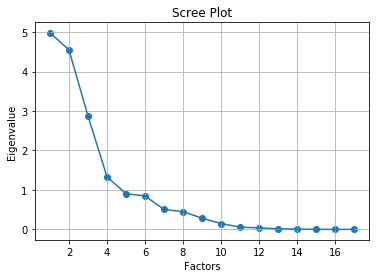

In [23]:
print(new_df_yes.columns)
factor_number_tester = FactorAnalyzer(n_factors=10, rotation="varimax") # Using number of factors = number of columns
factor_number_tester.fit(new_df_yes) 
ev, v = factor_number_tester.get_eigenvalues()

plt.scatter(range(1,new_df_yes.shape[1]+1),ev)
plt.plot(range(1,new_df_yes.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()


In [24]:
import numpy as np
fa = FactorAnalyzer(4, rotation="varimax")
fa.fit(new_df_yes)
print(new_df_yes.columns)
print(fa.loadings_)
print(np.where(fa.loadings_>0.7))
print(fa.get_factor_variance())

Index(['Duration', 'RPE', 'SessionLoad', 'DailyLoad', 'AcuteChronicRatio',
       'ObjectiveRating', 'FocusRating', 'BestOutOfMyself', 'AcuteLoad',
       'ChronicLoad', 'SessionType_Combat', 'SessionType_Conditioning',
       'SessionType_Game', 'SessionType_Mobility/Recovery',
       'SessionType_Skills', 'SessionType_Speed', 'SessionType_Strength'],
      dtype='object')
[[ 1.42824638e-01  3.27590799e-01  7.67954408e-01  7.73546819e-02]
 [ 4.30837958e-02  3.83120819e-02  2.57603574e-01  9.03805296e-01]
 [ 2.89070249e-01  1.04146629e-01  6.09479779e-01  7.20862769e-01]
 [ 4.89196267e-01  2.48569509e-01 -7.56312061e-02  7.92396724e-01]
 [-8.83596167e-01 -8.13509516e-02 -5.16430701e-04  3.38810081e-02]
 [ 5.81298933e-01 -5.81422268e-01 -2.13834157e-01  1.38557753e-01]
 [ 2.94189542e-01 -5.85736566e-01 -2.23462957e-01  3.01824372e-01]
 [-4.22427719e-02 -7.71687880e-02  4.45740291e-01  3.16948538e-01]
 [ 8.48447665e-01  8.98380291e-02 -1.25244419e-01  4.75417300e-01]
 [ 9.20998445e-01  7

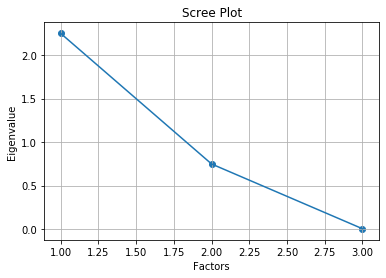

In [25]:
factor_number_tester = FactorAnalyzer(n_factors=5, rotation=None) # Using number of factors = number of columns
factor_number_tester.fit(no_without_nan_columns) 
ev, v = factor_number_tester.get_eigenvalues()

plt.scatter(range(1,no_without_nan_columns.shape[1]+1),ev)
plt.plot(range(1,no_without_nan_columns.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [26]:
fa = FactorAnalyzer(1,rotation = None)
fa.fit(no_without_nan_columns)
print(no_without_nan_columns.columns)
print(fa.loadings_)
print(np.where(fa.loadings_>0.5))
print(fa.get_factor_variance())

Index(['AcuteChronicRatio', 'AcuteLoad', 'ChronicLoad'], dtype='object')
[[-0.41435642]
 [ 0.94621714]
 [ 1.01815163]]
(array([1, 2]), array([0, 0]))
(array([2.10365085]), array([0.70121695]), array([0.70121695]))
